In [10]:
#Preliminary
using Pkg
Pkg.activate("..")
Pkg.instantiate()
Pkg.status()

  Activating project at `c:\Users\MGAJ\OneDrive - Danmarks Tekniske Universitet\DTU\Physics-Informed-Regression`
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API C:\Users\MGAJ\.julia\juliaup\julia-1.11.5+0.x64.w64.mingw32\share\julia\stdlib\v1.11\Pkg\src\API.jl:1206


Status `C:\Users\MGAJ\OneDrive - Danmarks Tekniske Universitet\DTU\Physics-Informed-Regression\Project.toml`
  [6e4b80f9] BenchmarkTools v1.6.0
  [479239e8] Catalyst v15.0.8
  [a93c6f00] DataFrames v1.7.0
  [0c46a032] DifferentialEquations v7.16.1
  [5b8099bc] DomainSets v0.7.15
  [a98d9a8b] Interpolations v0.16.1
  [b964fa9f] LaTeXStrings v1.4.0
  [23fbe1c1] Latexify v0.16.8
  [23992714] MAT v0.10.7
⌃ [94925ecb] MethodOfLines v0.11.8
⌅ [961ee093] ModelingToolkit v9.80.2
  [1dea7af3] OrdinaryDiffEq v6.98.0
  [b39d95ae] PhysicsInformedRegression v1.0.1 `https://github.com/MarcusGalea/PhysicsInformedRegression.jl.git#PDE_handling`
⌃ [91a5bcdd] Plots v1.40.13
  [08abe8d2] PrettyTables v2.4.0
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`
Warning The project dependencies or compat requirements have changed since the manifest was las

In [11]:
using ModelingToolkit, MethodOfLines, OrdinaryDiffEq, DomainSets
using PhysicsInformedRegression,Plots, Interpolations

# Burger's Equation
This notebook demonstrates the usage of `PhysicsInformedRegression.jl` as a datadriven method to estimate the diffusion coefficient $\nu$ in the Burger's equation.
$$
\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}
$$



## Simulation parameters 
The setup for the simulation is as follows:
given the boundary conditions
$$
\begin{align}
    u(0, x) &= -\sin(\pi x) \\
    u(t, -1) &= 0 \\
    u(t, 1) &= 0
\end{align}
$$
In the domain $t \in [0, 1]$ and $x \in [-1, 1]$, we simulate the solution of the Burger's equation with $\nu = 0.01$ sampling 100 points in the time domain and 100 points in the space domain. 

In [12]:
@parameters ν
@independent_variables t x
@variables u(..)
Dx = Differential(x)
Dxx = Differential(x)^2
Dt = Differential(t)

parameterdict = Dict(ν =>0.1) #ground truth

eq  = Dt(u(t,x)) + u(t,x)*Dx(u(t,x))~ ν*Dxx(u(t,x))

# Initial and boundary conditions
bcs = [u(0,x) ~ -sin(π*x), # initial condition 
        u(t,-1) ~ 0.0, # left boundary condition
        u(t,1) ~ 0.0] # right boundary condition
# Note: The initial condition is a sine wave, which is a common choice for testing the Burgers' equation.
# Space and time domains
domains = [t ∈ (0.0,1.0),
            x ∈ (-1.0,1.0)]
            

@named pdesys = PDESystem(eq,bcs,domains,[t,x],[u(t,x)], [ν], defaults = parameterdict)


PDESystem
Equations: Equation[Differential(t)(u(t, x)) + Differential(x)(u(t, x))*u(t, x) ~ Differential(x)(Differential(x)(u(t, x)))*ν]
Boundary Conditions: Equation[u(0, x) ~ -sin(πx), u(t, -1) ~ 0.0, u(t, 1) ~ 0.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 1.0), Symbolics.VarDomainPairing(x, -1.0 .. 1.0)]
Dependent Variables: Num[u(t, x)]
Independent Variables: Num[t, x]
Parameters: Num[ν]
Default Parameter ValuesDict{Num, Float64}(ν => 0.1)

## Data generation using Finite Difference
we generate the data using a finite difference scheme. The data is generated by solving the Burger's equation with the given boundary conditions and initial condition.


In [13]:



# Method of lines discretization
dx = 0.01
dt = 0.01
order = 4

discretization = MOLFiniteDifference([x => dx], t, approx_order = order)
# Convert the PDE problem into an ODE problem
prob = discretize(pdesys,discretization, p = parameterdict)
sol = solve(prob, Tsit5(), saveat=dt)

pde_discretized,timeinterval = symbolic_discretize(pdesys, discretization)
# A,b = setup_linear_system(pde_discretized)

pde_discretized = complete(pde_discretized)
#solve the ODE problem
# prob = ODEProblem(pde_discretized)

discrete_x = sol[x]
discrete_t = sol[t]

solu = sol[u(t, x)]

101×201 Matrix{Float64}:
 0.0  0.0314108   0.0627905  0.0941083  …  -0.0627905  -0.0314108   0.0
 0.0  0.0301668   0.0603128  0.0904111     -0.0603128  -0.0301668   0.0
 0.0  0.0290339   0.0580476  0.0870169     -0.0580476  -0.0290339   0.0
 0.0  0.0279971   0.0559672  0.0838882     -0.0559672  -0.0279971   0.0
 0.0  0.0270299   0.0540423  0.0810178     -0.0540423  -0.0270299   0.0
 0.0  0.0261398   0.0522614  0.0783474  …  -0.0522614  -0.0261398   0.0
 0.0  0.0253105   0.050605   0.0758676     -0.050605   -0.0253105   0.0
 0.0  0.0245374   0.0490603  0.0735543     -0.0490603  -0.0245374   0.0
 0.0  0.0238145   0.0476157  0.0713904     -0.0476157  -0.0238145   0.0
 0.0  0.0231366   0.0462611  0.0693612     -0.0462611  -0.0231366   0.0
 ⋮                                      ⋱                           ⋮
 0.0  0.00708562  0.0141699  0.0212516     -0.0141699  -0.00708562  0.0
 0.0  0.00702231  0.0140432  0.0210612     -0.0140432  -0.00702231  0.0
 0.0  0.00695968  0.013918   0.0208737   

## Illustration of the data

┌ Info: Saved animation to c:\Users\MGAJ\OneDrive - Danmarks Tekniske Universitet\DTU\Physics-Informed-Regression\plots\burgers_equation_solution.gif
└ @ Plots C:\Users\MGAJ\.julia\packages\Plots\MR7sb\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\MGAJ\\OneDrive - Danmarks Tekniske Universitet\\DTU\\Physics-Informed-Regression\\plots\\burgers_equation_solution.gif")
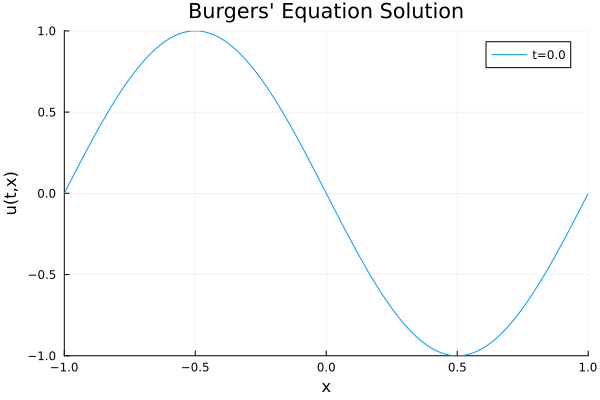

In [14]:
anim = @animate for i in 1:length(discrete_t)
    plot(discrete_x, solu[i,:], label="t=$(discrete_t[i])", xlabel="x", ylabel="u(t,x)", title="Burgers' Equation Solution", legend=:topright, xlims=(-1, 1), ylim=(-1, 1))
end
gif(anim, "../plots/burgers_equation_solution.gif", fps=10)

### PIR with discrete differential calculus
The package `PhysicsInformedRegression.jl` approximates both spatial and temporal derivatives first and second order derivatives using central differences.
for observations of the temperature field $u(t,x)$ at a set of points $(t_i, x_j)$, the first and second derivatives are approximated as follows:
$$
\begin{align*}
\frac{\partial u}{\partial t} &\approx \frac{u(t_{i+1}, x_j) - u(t_{i-1}, x_j)}{2\Delta t} \\
\frac{\partial^2 u}{\partial x^2} &\approx \frac{u(t_i, x_{j+1}) - 2u(t_i, x_j) + u(t_i, x_{j-1})}{(\Delta x)^2}
\end{align*}
$$ 
Where $\Delta t$ and $\Delta x$ are the time and space step sizes, respectively. The approximations of the moments are compared against their analytical counterparts.

In [15]:
# Setup model for regression
using Latexify
using LaTeXStrings

A,b = PhysicsInformedRegression.setup_linear_system(pdesys)
A_sym = latexify(A)
b_sym = latexify(b)
display(L"A = %$A_sym")
display(L"b = %$b_sym")

L"$A = \begin{equation}
\left[
\begin{array}{c}
\frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) \\
\end{array}
\right]
\end{equation}
$"

L"$b = \begin{equation}
\left[
\begin{array}{c}
\frac{\mathrm{d}}{\mathrm{d}t} u\left( t, x \right) + \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) u\left( t, x \right) \\
\end{array}
\right]
\end{equation}
$"

where $A$ is the matrix of parameters and $b$ is the right-hand side vector. The goal is to find the parameters that minimize the residuals of the system, which can be formulated as a least squares problem. 
$$
\begin{align*}
    \nu^* &= \min_{\nu} \| A \cdot \nu - b \|^2\\
    &= (A^T A)^{-1} A^T b
\end{align*}
$$
Where $\nu^*$ is the estimated diffusion and $\| \cdot \|$ denotes the Euclidean norm. $A$ and $b$ are evaluated and vertically concatenated for all spatiotemporal observations in the dataset.

In [16]:
λ = 0 # regularization parameter
paramsest = physics_informed_regression(pdesys, sol; lambda = λ)
# Compare the estimated parameters to the true parameters
for (i, param) in enumerate(parameters(pdesys))
    println("Parameter $(param) = $(parameterdict[param]) estimated as $(paramsest[param])")
    #relative error
    rel_error = abs((paramsest[param] - parameterdict[param]) / parameterdict[param])
    println("Relative error: $(rel_error)")
end

Parameter ν = 0.1 estimated as 0.10285607547134734
Relative error: 0.028560754713473357
